# Mapping of HLCA extension datasets to the HLCA core using scArches

### To do: see if we can leave out the loading of the reference adata (old input data, including clusters later filtered out)

Here we'll map all the datasets from the HLCA extension to the HLCA core, by using [scArches](https://www.nature.com/articles/s41587-021-01001-7). As a basis model for the mapping, we'll use the model that was generated by scANVI for integration of the core datasets.
Note that we use scArches version 0.3.5 and scvi tools version 0.8.1 here.

# Mapping of atlas extensions datasets to the HLCA core

Here we map the datasets from the extension to the HLCA core one by one, using scArches. 

### Import modules, set paths, load files:

In [1]:
import scanpy as sc
import anndata
import numpy as np
import pandas as pd
import os

In [3]:
import scarches as sca

In [4]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

for code formatting, if wanted:

In [5]:
%load_ext lab_black

set figure params, if wanted:

In [6]:
sc.set_figure_params(dpi=120, figsize=(8, 8))

set paths:

In [7]:
path_input_core_data = (
    "../../data/HLCA_core_h5ads/HLCA_v1_integration/HLCA_v1_scANVI_input.h5ad"
)
path_final_core_data = "../../data/HLCA_core_h5ads/HLCA_v2.h5ad"
path_input_extension_data = (
    "../../data/HLCA_extended/HLCA_extended/extension_data_pooled_raw_2000genes.h5ad"
)
dir_out_hlca_extended = "../../data/HLCA_extended/HLCA_extended"
dir_reference_model = "../../results/scANVI_integration/scanvi_model"  # directory where the reference model is stored
dir_surgery_models = "../../data/HLCA_extended/HLCA_extended_models_and_embs/surgery_models"  # directory where surgery model(s) will be stored
dir_surgery_embs = (
    "../../data/HLCA_extended/HLCA_extended_models_and_embs/surgery_output_embeddings"
)
dir_figures = "../../results/figures/"

set relevant adata.obs labels to use for integration:

In [8]:
condition_key = "dataset"
cell_type_key = "scanvi_label"
unlabeled_category = "unlabeled"

## Import final filtered reference adata (atlas core, clean):

In [3]:
reference_adata_clean = sc.read(path_final_core_data)

## Import raw, original input reference adata (atlas core, raw):

In [9]:
reference_adata = sc.read(path_input_core_data)

In [10]:
reference_adata.shape

(587218, 2000)

In [11]:
reference_adata.var.head(5)

gene_symbols  n_cells  highly_variable     means  dispersions  \
ENSG00000000938          FGR   107870             True  0.203495     1.104081   
ENSG00000000971          CFH   113428             True  0.188413     1.086728   
ENSG00000002587       HS3ST1    82919             True  0.158216     1.075575   
ENSG00000002933     TMEM176A    36999             True  0.061320     1.334051   
ENSG00000003436         TFPI   136851             True  0.270989     1.222142   

                 dispersions_norm  highly_variable_nbatches  \
ENSG00000000938          2.025088                         5   
ENSG00000000971          2.930069                         7   
ENSG00000002587          2.524420                         8   
ENSG00000002933          6.511887                        11   
ENSG00000003436          3.246769                         8   

                 highly_variable_intersection  
ENSG00000000938                         False  
ENSG00000000971                         False  
ENSG00000002587                         False  
ENSG00000002933                         False  
ENSG00000003436                         False

set var index to gene symbols instead of ensembl IDs:

In [12]:
reference_adata.var["gene_ids"] = reference_adata.var.index.tolist()
reference_adata.var.index = reference_adata.var.gene_symbols.values
reference_adata.var.drop(columns="gene_symbols", inplace=True)

In [13]:
reference_adata.var.head(5)

n_cells  highly_variable     means  dispersions  dispersions_norm  \
FGR        107870             True  0.203495     1.104081          2.025088   
CFH        113428             True  0.188413     1.086728          2.930069   
HS3ST1      82919             True  0.158216     1.075575          2.524420   
TMEM176A    36999             True  0.061320     1.334051          6.511887   
TFPI       136851             True  0.270989     1.222142          3.246769   

          highly_variable_nbatches  highly_variable_intersection  \
FGR                              5                         False   
CFH                              7                         False   
HS3ST1                           8                         False   
TMEM176A                        11                         False   
TFPI                             8                         False   

                 gene_ids  
FGR       ENSG00000000938  
CFH       ENSG00000000971  
HS3ST1    ENSG00000002587  
TMEM176A  ENSG00000002933  
TFPI      ENSG00000003436

plot cell type labels that were used for scANVI integration:

In [11]:
sc.set_figure_params(figsize=(8,8))

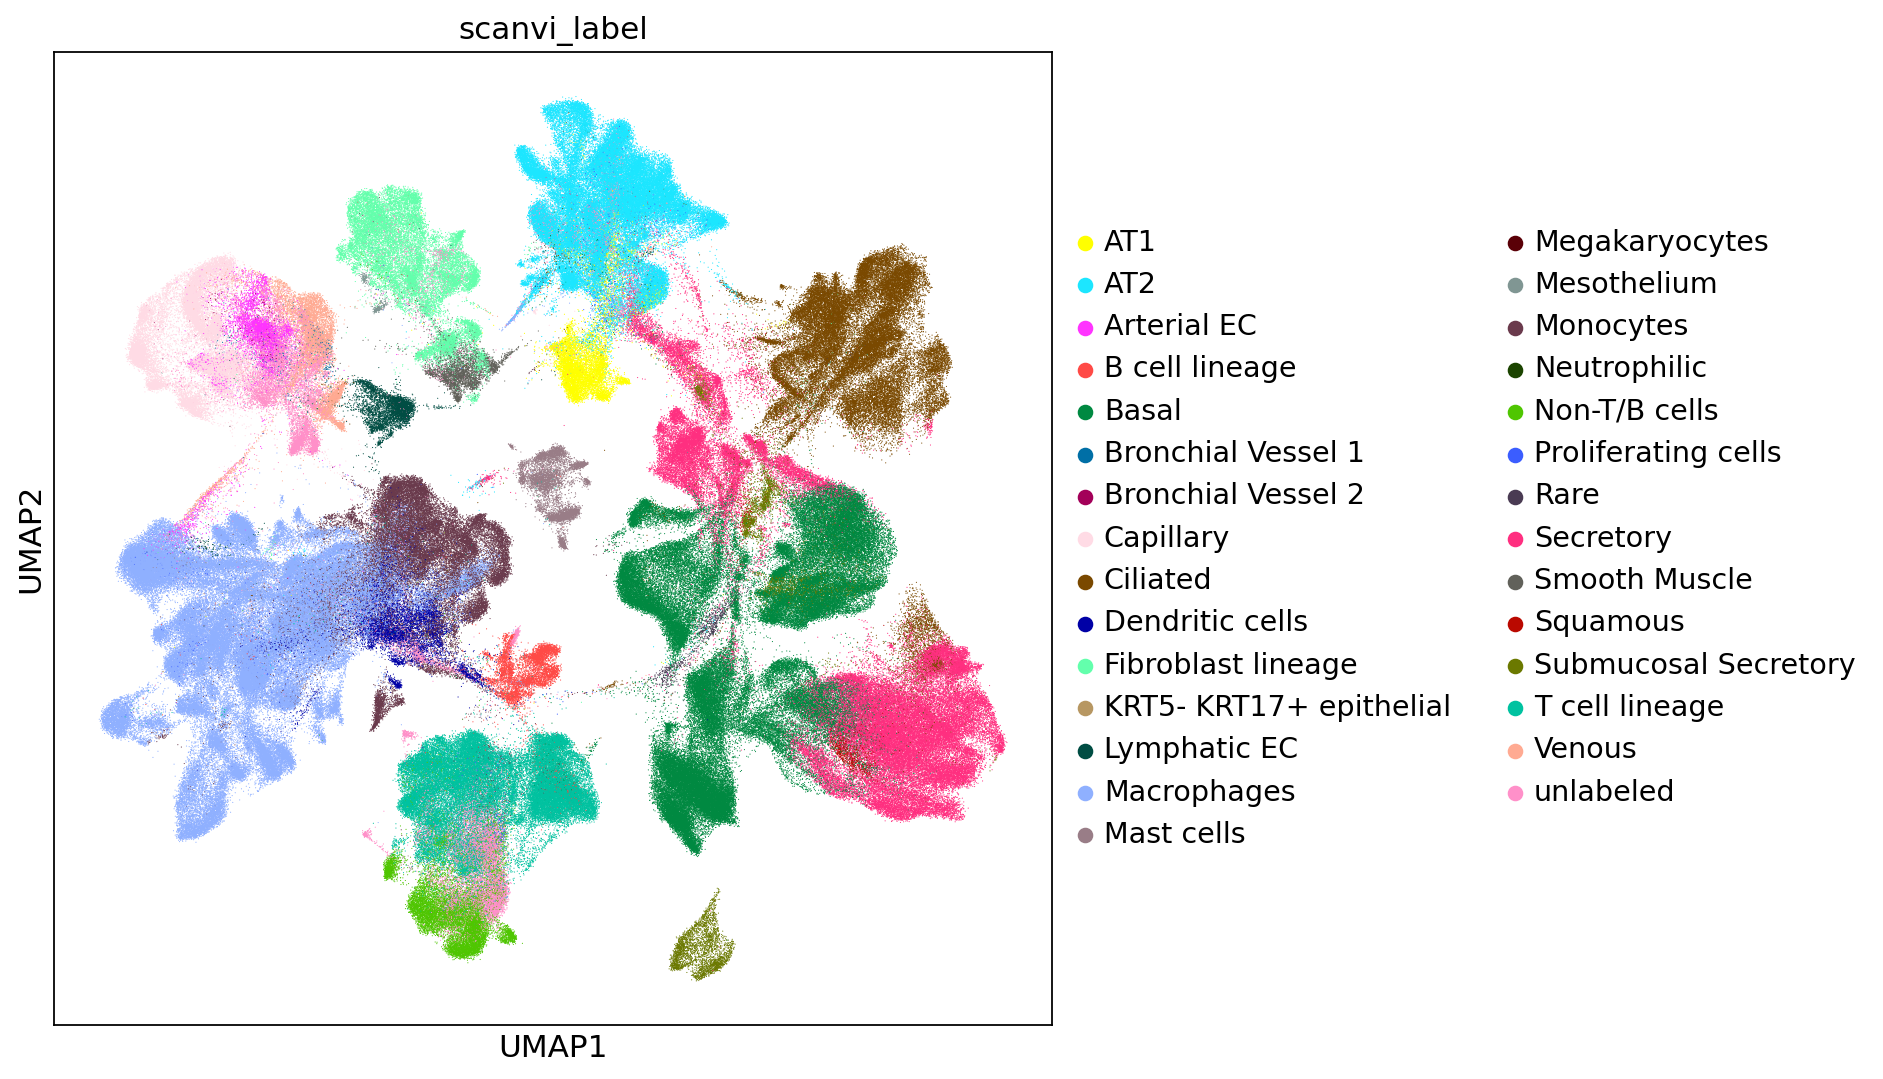

In [12]:
sc.pl.umap(reference_adata,color='scanvi_label',size=1)

# Import query data:

i.e. data to be mapped

In [14]:
query_adata = sc.read_h5ad(path_input_extension_data)

In [15]:
query_adata

AnnData object with n_obs × n_vars = 2232596 × 2000
    obs: 'sample', 'original_celltype_ann', 'study_long', 'study', 'last_author_PI', 'subject_ID', 'subject_ID_as_published', 'pre_or_postnatal', 'age_in_years', 'age_range', 'sex', 'ethnicity', 'mixed_ethnicity', 'smoking_status', 'smoking_history', 'BMI', 'known_lung_disease', 'condition', 'subject_type', 'cause_of_death', 'sample_type', 'anatomical_region_coarse', 'anatomical_region_detailed', 'tissue_dissociation_protocol', 'cells_or_nuclei', 'single_cell_platform', "3'_or_5'", 'enrichment', 'sequencing_platform', 'reference_genome_coarse', 'ensembl_release_reference_genome', 'cell_ranger_version', 'disease_status', 'fresh_or_frozen', 'cultured', 'cell_viability_%', 'comments', 'Processing_site', 'dataset', 'anatomical_region_level_1', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'ori

sort genes in the same order as the reference adata:

In [16]:
query_adata = query_adata[:, reference_adata.var.index].copy()

In [17]:
query_adata

AnnData object with n_obs × n_vars = 2232596 × 2000
    obs: 'sample', 'original_celltype_ann', 'study_long', 'study', 'last_author_PI', 'subject_ID', 'subject_ID_as_published', 'pre_or_postnatal', 'age_in_years', 'age_range', 'sex', 'ethnicity', 'mixed_ethnicity', 'smoking_status', 'smoking_history', 'BMI', 'known_lung_disease', 'condition', 'subject_type', 'cause_of_death', 'sample_type', 'anatomical_region_coarse', 'anatomical_region_detailed', 'tissue_dissociation_protocol', 'cells_or_nuclei', 'single_cell_platform', "3'_or_5'", 'enrichment', 'sequencing_platform', 'reference_genome_coarse', 'ensembl_release_reference_genome', 'cell_ranger_version', 'disease_status', 'fresh_or_frozen', 'cultured', 'cell_viability_%', 'comments', 'Processing_site', 'dataset', 'anatomical_region_level_1', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'ori

In [18]:
query_adata.var.head(5)

gene_symbols-0  n_cells-0  highly_variable-0   means-0  \
FGR                 FGR     107870               True  0.203495   
CFH                 CFH     113428               True  0.188413   
HS3ST1           HS3ST1      82919               True  0.158216   
TMEM176A       TMEM176A      36999               True  0.061320   
TFPI               TFPI     136851               True  0.270989   

          dispersions-0  dispersions_norm-0  highly_variable_nbatches-0  \
FGR            1.104081            2.025088                           5   
CFH            1.086728            2.930069                           7   
HS3ST1         1.075575            2.524420                           8   
TMEM176A       1.334051            6.511887                          11   
TFPI           1.222142            3.246769                           8   

          highly_variable_intersection-0       gene_ids-0  
FGR                                False  ENSG00000000938  
CFH                                False  ENSG00000000971  
HS3ST1                             False  ENSG00000002587  
TMEM176A                           False  ENSG00000002933  
TFPI                               False  ENSG00000003436

# Set relevant layers to raw counts: 

already done for reference:

In [19]:
reference_adata.X[:10,:10].toarray()

array([[0., 3., 0., 0., 5., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [2., 0., 0., 0., 0., 0., 0., 0., 0., 2.],
       [0., 2., 3., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 2., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 2., 0., 0., 0., 0., 0.]], dtype=float32)

In [20]:
reference_adata.raw.X[:10,:10].toarray()

array([[0., 3., 0., 0., 5., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [2., 0., 0., 0., 0., 0., 0., 0., 0., 2.],
       [0., 2., 3., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 2., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 2., 0., 0., 0., 0., 0.]], dtype=float32)

### set .Raw to counts:

if data are raw counts already, create a raw layer as follows:

In [21]:
query_adata.raw = query_adata
raw = query_adata.raw.to_adata()
raw.X = query_adata.X
query_adata.raw = raw

quick check if X and raw.X have integers:

In [22]:
query_adata.raw.X[:10,:10].toarray()

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.69, 0.  , 0.  , 0.69],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.82, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.82],
       [0.  , 0.24, 0.34, 0.  , 0.  , 0.  , 0.12, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 1.57, 0.  , 1.07, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.52],
       [0.  , 0.  , 0.  , 0.  , 2.55, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 2.37]],
      dtype=float32)

In [23]:
query_adata.X[:10,:10].toarray()

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.69, 0.  , 0.  , 0.69],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.82, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.82],
       [0.  , 0.24, 0.34, 0.  , 0.  , 0.  , 0.12, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 1.57, 0.  , 1.07, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.52],
       [0.  , 0.  , 0.  , 0.  , 2.55, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 2.37]],
      dtype=float32)

set cell type key to unlabeled:

In [24]:
query_adata.obs[cell_type_key] = unlabeled_category

In [25]:
reference_adata.obs.dataset.unique()

['Teichmann_Meyer_2019', 'Misharin_Budinger_2018', 'Krasnow_2020', 'Seibold_2020_10Xv3', 'Banovich_Kropski_2020', ..., 'Lafyatis_Rojas_2019_10Xv1', 'Lafyatis_Rojas_2019_10Xv2', 'Meyer_2019', 'Jain_Misharin_2021_10Xv2', 'Jain_Misharin_2021_10Xv1']
Length: 14
Categories (14, object): ['Teichmann_Meyer_2019', 'Misharin_Budinger_2018', 'Krasnow_2020', 'Seibold_2020_10Xv3', ..., 'Lafyatis_Rojas_2019_10Xv2', 'Meyer_2019', 'Jain_Misharin_2021_10Xv2', 'Jain_Misharin_2021_10Xv1']

### Perform surgery on reference model and train on query dataset without cell type labels

set params:

In [26]:
query_conditions = [ds for ds in query_adata.obs.dataset.unique().tolist() if ds not in reference_adata.obs.dataset.unique()]
surgery_epochs = 500
early_stopping_kwargs_surgery = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "on": "full_dataset",
    "patience": 10,
    "threshold": 0.001,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}

In [27]:
query_conditions = [
    ds
    for ds in query_adata.obs.dataset.unique().tolist()
    if ds not in reference_adata.obs.dataset.unique()
]

check if query conditions are as expected (these should be the added datasets/batches)

In [28]:
len(query_conditions)

32

Now perform the mapping and store the results:

In [ ]:
for condition in query_conditions[::-1]: # (going from small to large dataset, to see quickly if code is working)
    print(condition)
    query_subadata = query_adata[query_adata.obs.dataset == condition,:].copy()
    print(query_subadata.shape)
    # load model and set relevant variables:
    model = sca.models.SCANVI.load_query_data(
        query_subadata,
        dir_reference_model,
        freeze_dropout = True,
    )
    model._unlabeled_indices = np.arange(query_subadata.n_obs)
    model._labeled_indices = []
    print("Labelled Indices: ", len(model._labeled_indices))
    print("Unlabelled Indices: ", len(model._unlabeled_indices))
    # now train surgery model using reference model and query adata
    model.train(
        n_epochs_semisupervised=surgery_epochs,
        train_base_model=False,
        semisupervised_trainer_kwargs=dict(metrics_to_monitor=["accuracy", "elbo"], 
                                           weight_decay=0,
                                           early_stopping_kwargs=early_stopping_kwargs_surgery
                                          ),
        frequency=1
    )
    surgery_path = os.path.join(dir_surgery_models, condition)
    if not os.path.exists(surgery_path):
        os.makedirs(surgery_path)
    model.save(surgery_path, overwrite=True)

Lambrechts_2021
(65166, 2000)
WARNING  var_names for adata passed in does not match var_names of adata used to train the   
         model. For valid results, the vars need to be the same and in the same order as the 
         adata used to train the model.                                                      
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 65166 cells, 2000 vars, 15        
         batches, 29 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
Labelled Indices:  0
Unlabelled Indices:  65166
INFO     Training Unsupervised Trainer for 123 epochs.                      

to reload specific models, use the following code:

In [ ]:
# model = sca.models.SCANVI.load_query_data(query_adata, 'surgery_model', freeze_dropout=True) # this is before training

In [ ]:
# model = sca.models.SCANVI.load(surgery_path,query_adata) # if already trained

### Get latent representation of (reference +) query dataset:

(same as before, only include datasets that were not also present in the reference/core (some are in both))

In [29]:
query_conditions = [
    ds
    for ds in query_adata.obs.dataset.unique().tolist()
    if ds not in reference_adata.obs.dataset.unique()
]

In [32]:
sorted(query_conditions)

['Barbry_unpubl',
 'Budinger_2020',
 'Duong_lungMAP_unpubl',
 'Eils_2020',
 'Gomperts2021_UCLA',
 'Gomperts_2021_CFF',
 'Gomperts_2021_CSMC',
 'Janssen_2020',
 'Kaminski_2020',
 'Lafyatis_2019',
 'Lambrechts_2021',
 'Meyer_2021_3prime',
 'Meyer_2021_5prime',
 'Peer_Massague_2020',
 'Regev_2021_Cryo',
 'Regev_2021_Fresh',
 'Regev_2021_Nuclei',
 'Schiller_2020',
 'Schiller_2021',
 'Shalek_2018',
 'Sheppard_2020',
 'Sims_2019',
 'Sun_2020_batch1',
 'Sun_2020_batch2',
 'Sun_2020_batch3',
 'Sun_2020_batch4',
 'Thienpont_2018_10Xv1',
 'Thienpont_2018_10Xv2',
 'Wunderink_2021_cryo',
 'Wunderink_2021_fresh',
 'Xu_2020_LAM1_3',
 'Zhang_2021']

Get embeddings (for query dataset only, not combined with reference because should be the same every time) and store:

This doesn't run for all batches atm as dataset labels (i.e. batch labels) have changed in the updated atlas for some datasets, and the original labels are hardcoded in the models (e.g. Lafyatis_2019):

In [33]:
for dataset in query_conditions[::-1]: # from small to large datasets
    print(f"Working on {dataset}...")
    query_subadata = query_adata[query_adata.obs.dataset == dataset,:].copy()
    surgery_path = os.path.join(dir_surgery_models, dataset)
    model = sca.models.SCANVI.load(surgery_path,query_subadata)
    query_subadata_latent = sc.AnnData(model.get_latent_representation(adata=query_subadata))
    query_subadata_latent.obs.index = query_subadata.obs.index
    query_subadata_latent.write(os.path.join(dir_surgery_embs, f"{dataset}_emb.h5ad"))

Working on Lambrechts_2021...
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 65166 cells, 2000 vars, 15        
         batches, 29 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
Working on Sun_2020_batch4...
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 16854 cells, 2000 vars, 15        


ValueError: Making .obs["dataset"] categorical failed. Expected categories: ['Banovich_Kropski_2020' 'Barbry_Leroy_2020' 'Jain_Misharin_2021_10Xv1'
 'Jain_Misharin_2021_10Xv2' 'Krasnow_2020' 'Lafyatis_Rojas_2019_10Xv1'
 'Lafyatis_Rojas_2019_10Xv2' 'Meyer_2019' 'Misharin_2021'
 'Misharin_Budinger_2018' 'Nawijn_2021' 'Seibold_2020_10Xv2'
 'Seibold_2020_10Xv3' 'Teichmann_Meyer_2019' 'Lafyatis_Rojas_2019_disease']. Received categories: Index(['Lafyatis_2019'], dtype='object'). 

get embeddings for newly added cells from datasets already present in the LCA (i.e. reference); for these "extensions" of datasets in the core we did not learn any adapters/do any surgery.

In [29]:
for dataset in query_adata.obs.dataset.unique():
    if dataset not in query_conditions:
        print(f"Working on {dataset}...")
        query_subadata = query_adata[query_adata.obs.dataset == dataset,:].copy()
        model = sca.models.SCANVI.load(dir_reference_model,query_subadata)
        query_subadata_latent = sc.AnnData(model.get_latent_representation(adata=query_subadata))
        query_subadata_latent.obs.index = query_subadata.obs.index
        query_subadata_latent.write(os.path.join(dir_surgery_embs, f"{dataset}_emb_LCAv2_no_surgery.h5ad"))

Working on Banovich_Kropski_2020...
WARNING  var_names for adata passed in does not match var_names of adata used to train the   
         model. For valid results, the vars need to be the same and in the same order as the 
         adata used to train the model.                                                      
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 82692 cells, 2000 vars, 14        
         batches, 29 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
Working on Misharin_Budinger_2018...
WARNING  var_names for adata passed in does not match var_names of adata used to 

## Update code from here, this is temporary:

Query and reference combined:

In [12]:
query_embs = dict()

In [30]:
for dataset in query_conditions:
    query_embs[dataset] =  sc.read_h5ad(os.path.join(dir_surgery_embs, f"{dataset}_emb_LCAv2.h5ad"))
for dataset in query_adata.obs.dataset.unique():
    if dataset not in query_conditions:
        print(dataset)
        query_embs[dataset] = sc.read_h5ad(os.path.join(dir_surgery_embs, f"{dataset}_emb_LCAv2_no_surgery.h5ad"))

Banovich_Kropski_2020
Misharin_Budinger_2018


In [32]:
ncells = 0
for query_adata_name, query_adata_dataset in query_embs.items():
    ncells += query_adata_dataset.n_obs

In [36]:
ncells == query_adata.n_obs

True

In [45]:
query_adata_latent_emb = sc.AnnData.concatenate(
    *query_embs.values(),
    join="outer",
    batch_key=None,
    batch_categories=list(query_embs.keys()),
    index_unique=None
)

In [49]:
query_adata_latent_emb.obs.index.isin(query_adata.obs.index).all()

True

In [51]:
query_adata.obsm['X_scanvi_emb'] = query_adata_latent_emb[query_adata.obs.index,:].X

Concatenate reference and query:

In [63]:
query_adata.obs["core_or_extension"] = "extension"
reference_adata_clean.obs["core_or_extension"] = "core"

In [64]:
# concatenate reference and query data
adata_full = reference_adata_clean.concatenate(query_adata, index_unique=None) #, batch_key=None, batch_categories=None)

store embedding:

In [65]:
full_latent = sc.AnnData(X=adata_full.obsm['X_scanvi_emb'], obs=adata_full.obs)

In [66]:
full_latent.write(os.path.join(dir_out_hlca_extended, "HLCA_extended_scarches_emb.h5ad"))

... storing 'sample' as categorical
... storing 'original_celltype_ann' as categorical
... storing 'study_long' as categorical
... storing 'study' as categorical
... storing 'last_author_PI' as categorical
... storing 'subject_ID' as categorical
... storing 'subject_ID_as_published' as categorical
... storing 'pre_or_postnatal' as categorical
... storing 'age_range' as categorical
... storing 'sex' as categorical
... storing 'ethnicity' as categorical
... storing 'mixed_ethnicity' as categorical
... storing 'smoking_status' as categorical
... storing 'smoking_history' as categorical
... storing 'known_lung_disease' as categorical
... storing 'condition' as categorical
... storing 'subject_type' as categorical
... storing 'cause_of_death' as categorical
... storing 'sample_type' as categorical
... storing 'anatomical_region_coarse' as categorical
... storing 'anatomical_region_detailed' as categorical
... storing 'tissue_dissociation_protocol' as categorical
... storing 'cells_or_nuclei

store full adata, if wanted:

In [67]:
adata_full.write(os.path.join(dir_out_hlca_extended, "extension_data_pooled_raw_2000genes.h5ad"))

... storing 'sample' as categorical
... storing 'original_celltype_ann' as categorical
... storing 'study_long' as categorical
... storing 'study' as categorical
... storing 'last_author_PI' as categorical
... storing 'subject_ID' as categorical
... storing 'subject_ID_as_published' as categorical
... storing 'pre_or_postnatal' as categorical
... storing 'age_range' as categorical
... storing 'sex' as categorical
... storing 'ethnicity' as categorical
... storing 'mixed_ethnicity' as categorical
... storing 'smoking_status' as categorical
... storing 'smoking_history' as categorical
... storing 'known_lung_disease' as categorical
... storing 'condition' as categorical
... storing 'subject_type' as categorical
... storing 'cause_of_death' as categorical
... storing 'sample_type' as categorical
... storing 'anatomical_region_coarse' as categorical
... storing 'anatomical_region_detailed' as categorical
... storing 'tissue_dissociation_protocol' as categorical
... storing 'cells_or_nuclei

## Calculate umap:

and calculate umap for full embedding if wanted (note that this is a very heavy and long calculation given the size of the full atlas, hence we store the results first above.)

In [9]:
full_latent = sc.read_h5ad(
    os.path.join(dir_out_hlca_extended, "HLCA_extended_scarches_emb.h5ad")
)

In [10]:
full_latent

AnnData object with n_obs × n_vars = 2382658 × 30
    obs: 'sample', 'original_celltype_ann', 'study_long', 'study', 'last_author_PI', 'subject_ID', 'subject_ID_as_published', 'pre_or_postnatal', 'age_in_years', 'age_range', 'sex', 'ethnicity', 'mixed_ethnicity', 'smoking_status', 'smoking_history', 'BMI', 'known_lung_disease', 'condition', 'subject_type', 'cause_of_death', 'sample_type', 'anatomical_region_coarse', 'anatomical_region_detailed', 'tissue_dissociation_protocol', 'cells_or_nuclei', 'single_cell_platform', "3'_or_5'", 'enrichment', 'sequencing_platform', 'reference_genome_coarse', 'ensembl_release_reference_genome', 'cell_ranger_version', 'disease_status', 'fresh_or_frozen', 'cultured', 'cell_viability_%', 'comments', 'Processing_site', 'dataset', 'anatomical_region_level_1', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new

In [11]:
sc.pp.neighbors(full_latent, n_neighbors=30, use_rep="X")

/home/icb/lisa.sikkema/miniconda3/envs/HLCA_basic/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
sc.tl.umap(full_latent)

In [13]:
full_latent.write(
    os.path.join(dir_out_hlca_extended, "HLCA_extended_scarches_emb.h5ad")
)

order cells so that core is plotted on top:

In [14]:
full_latent_ext_first = full_latent[
    full_latent.obs.loc[full_latent.obs.core_or_extension != "core", :].index.tolist()
    + full_latent.obs.loc[
        full_latent.obs.core_or_extension == "core", :
    ].index.tolist(),
    :,
].copy()

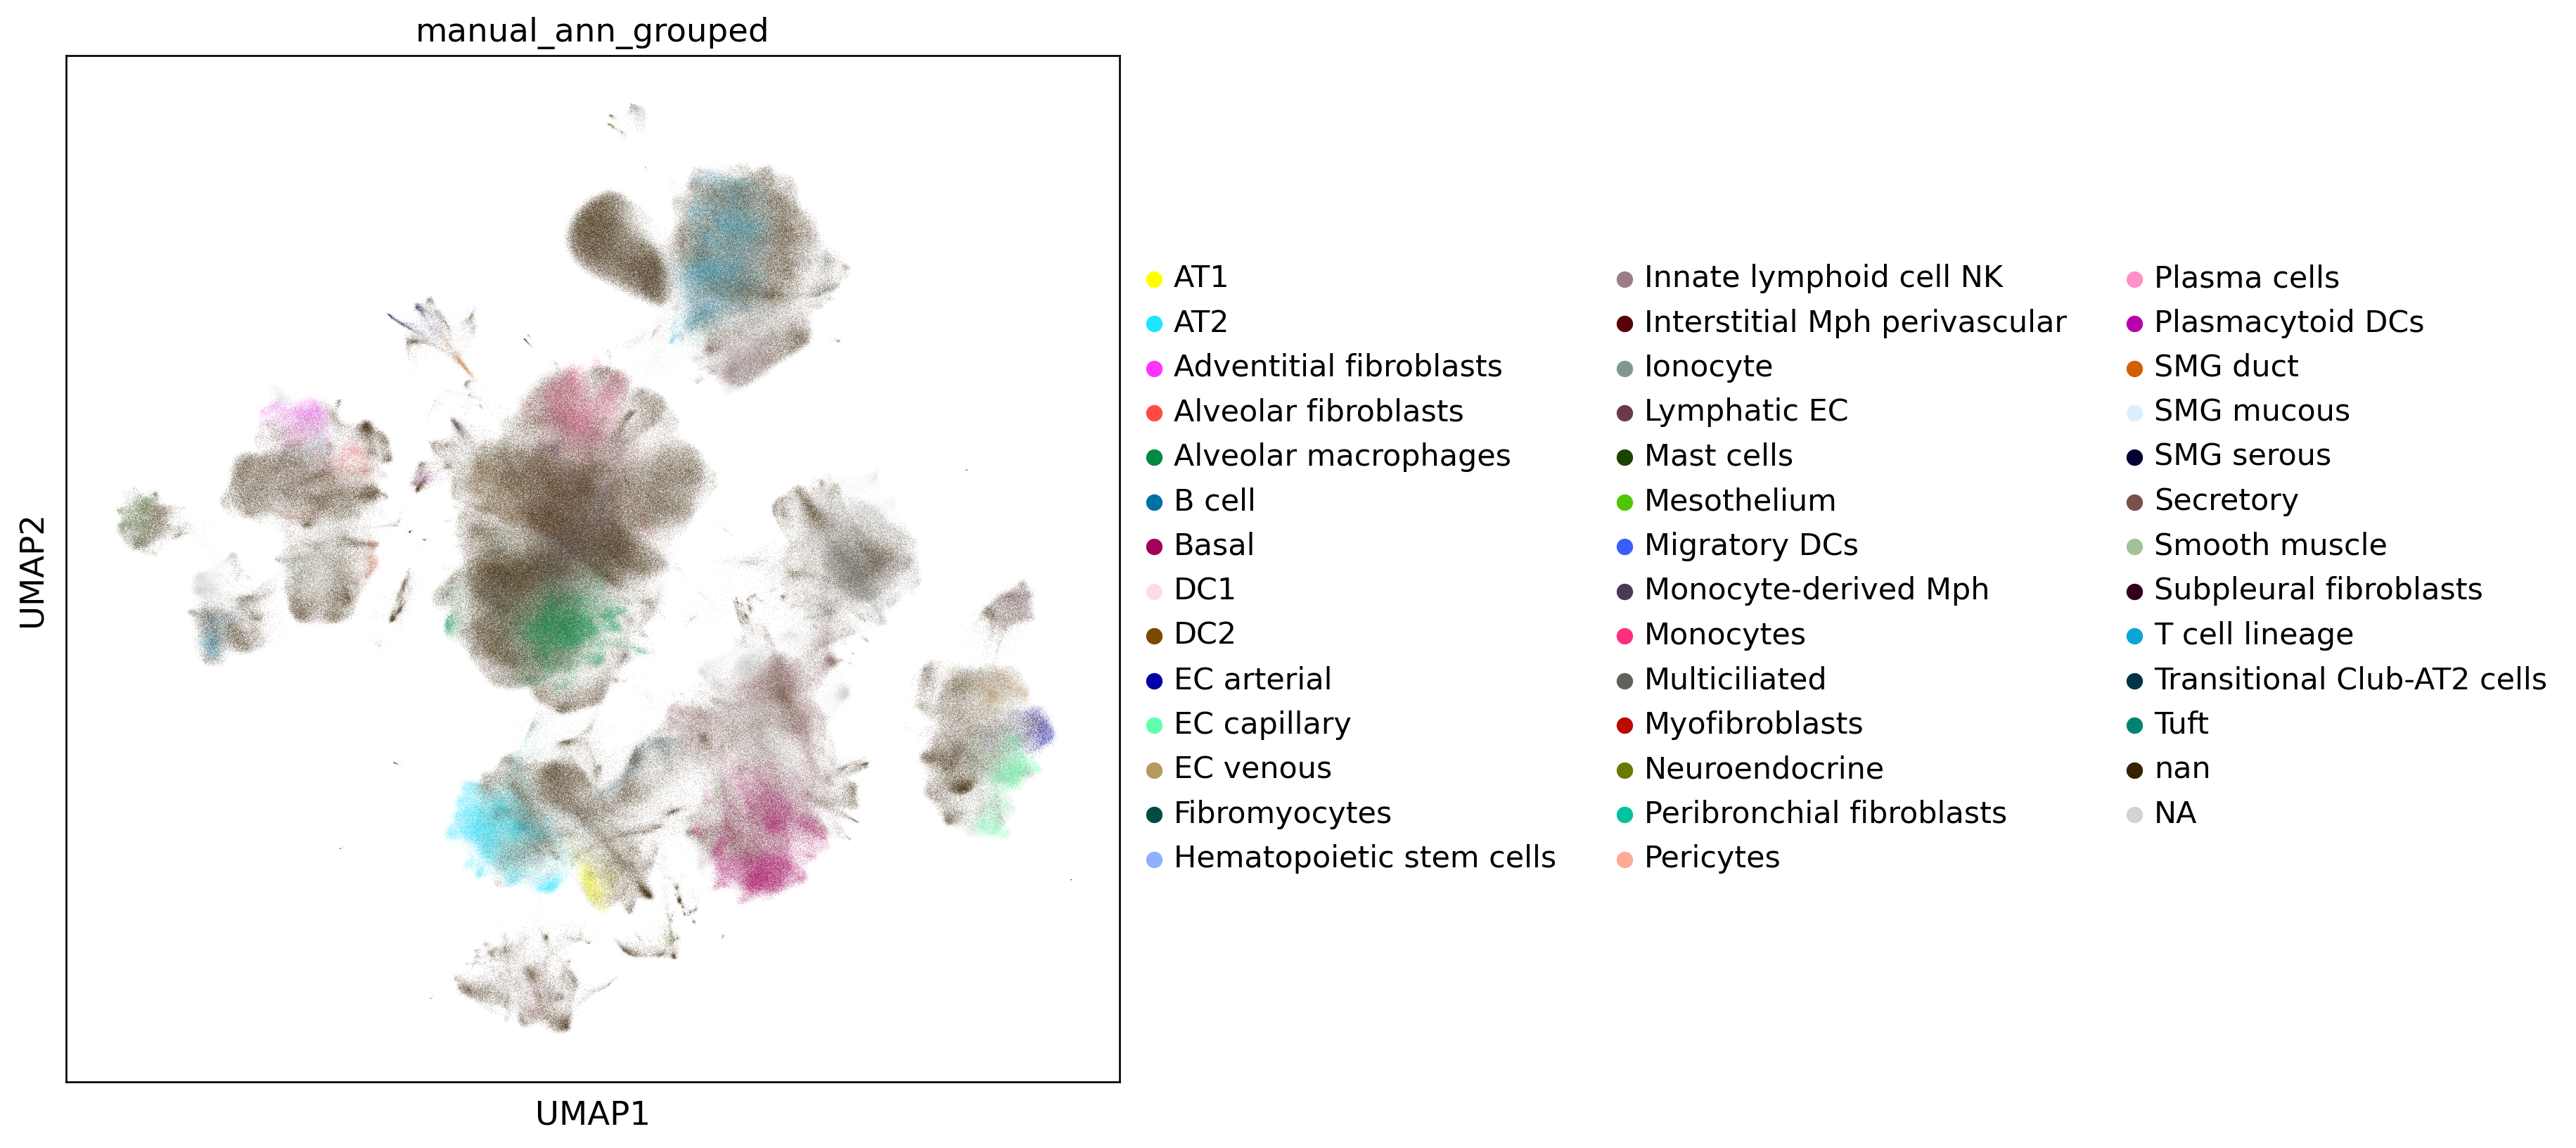

In [15]:
sc.pl.umap(full_latent_ext_first, color="manual_ann_grouped")

adapt color map:

In [16]:
cols_old = full_latent_ext_first.uns["manual_ann_grouped_colors"]

In [17]:
cols_new = {
    ct: col
    for ct, col in zip(
        full_latent_ext_first.obs.manual_ann_grouped.cat.categories, cols_old
    )
}

set nan and NA to "Extended atlas", as the extended atlas has no manual annotations:

In [18]:
full_latent_ext_first.obs.manual_ann_grouped = (
    full_latent_ext_first.obs.manual_ann_grouped.tolist()
)
full_latent_ext_first.obs.loc[
    full_latent_ext_first.obs.manual_ann_grouped == "nan", "manual_ann_grouped"
] = "Extended atlas"
full_latent_ext_first.obs.loc[
    pd.isnull(full_latent_ext_first.obs.manual_ann_grouped), "manual_ann_grouped"
] = "Extended atlas"

set extended atlas to grey:

In [19]:
cols_new["Extended atlas"] = "#BEBEBE"

and plot:

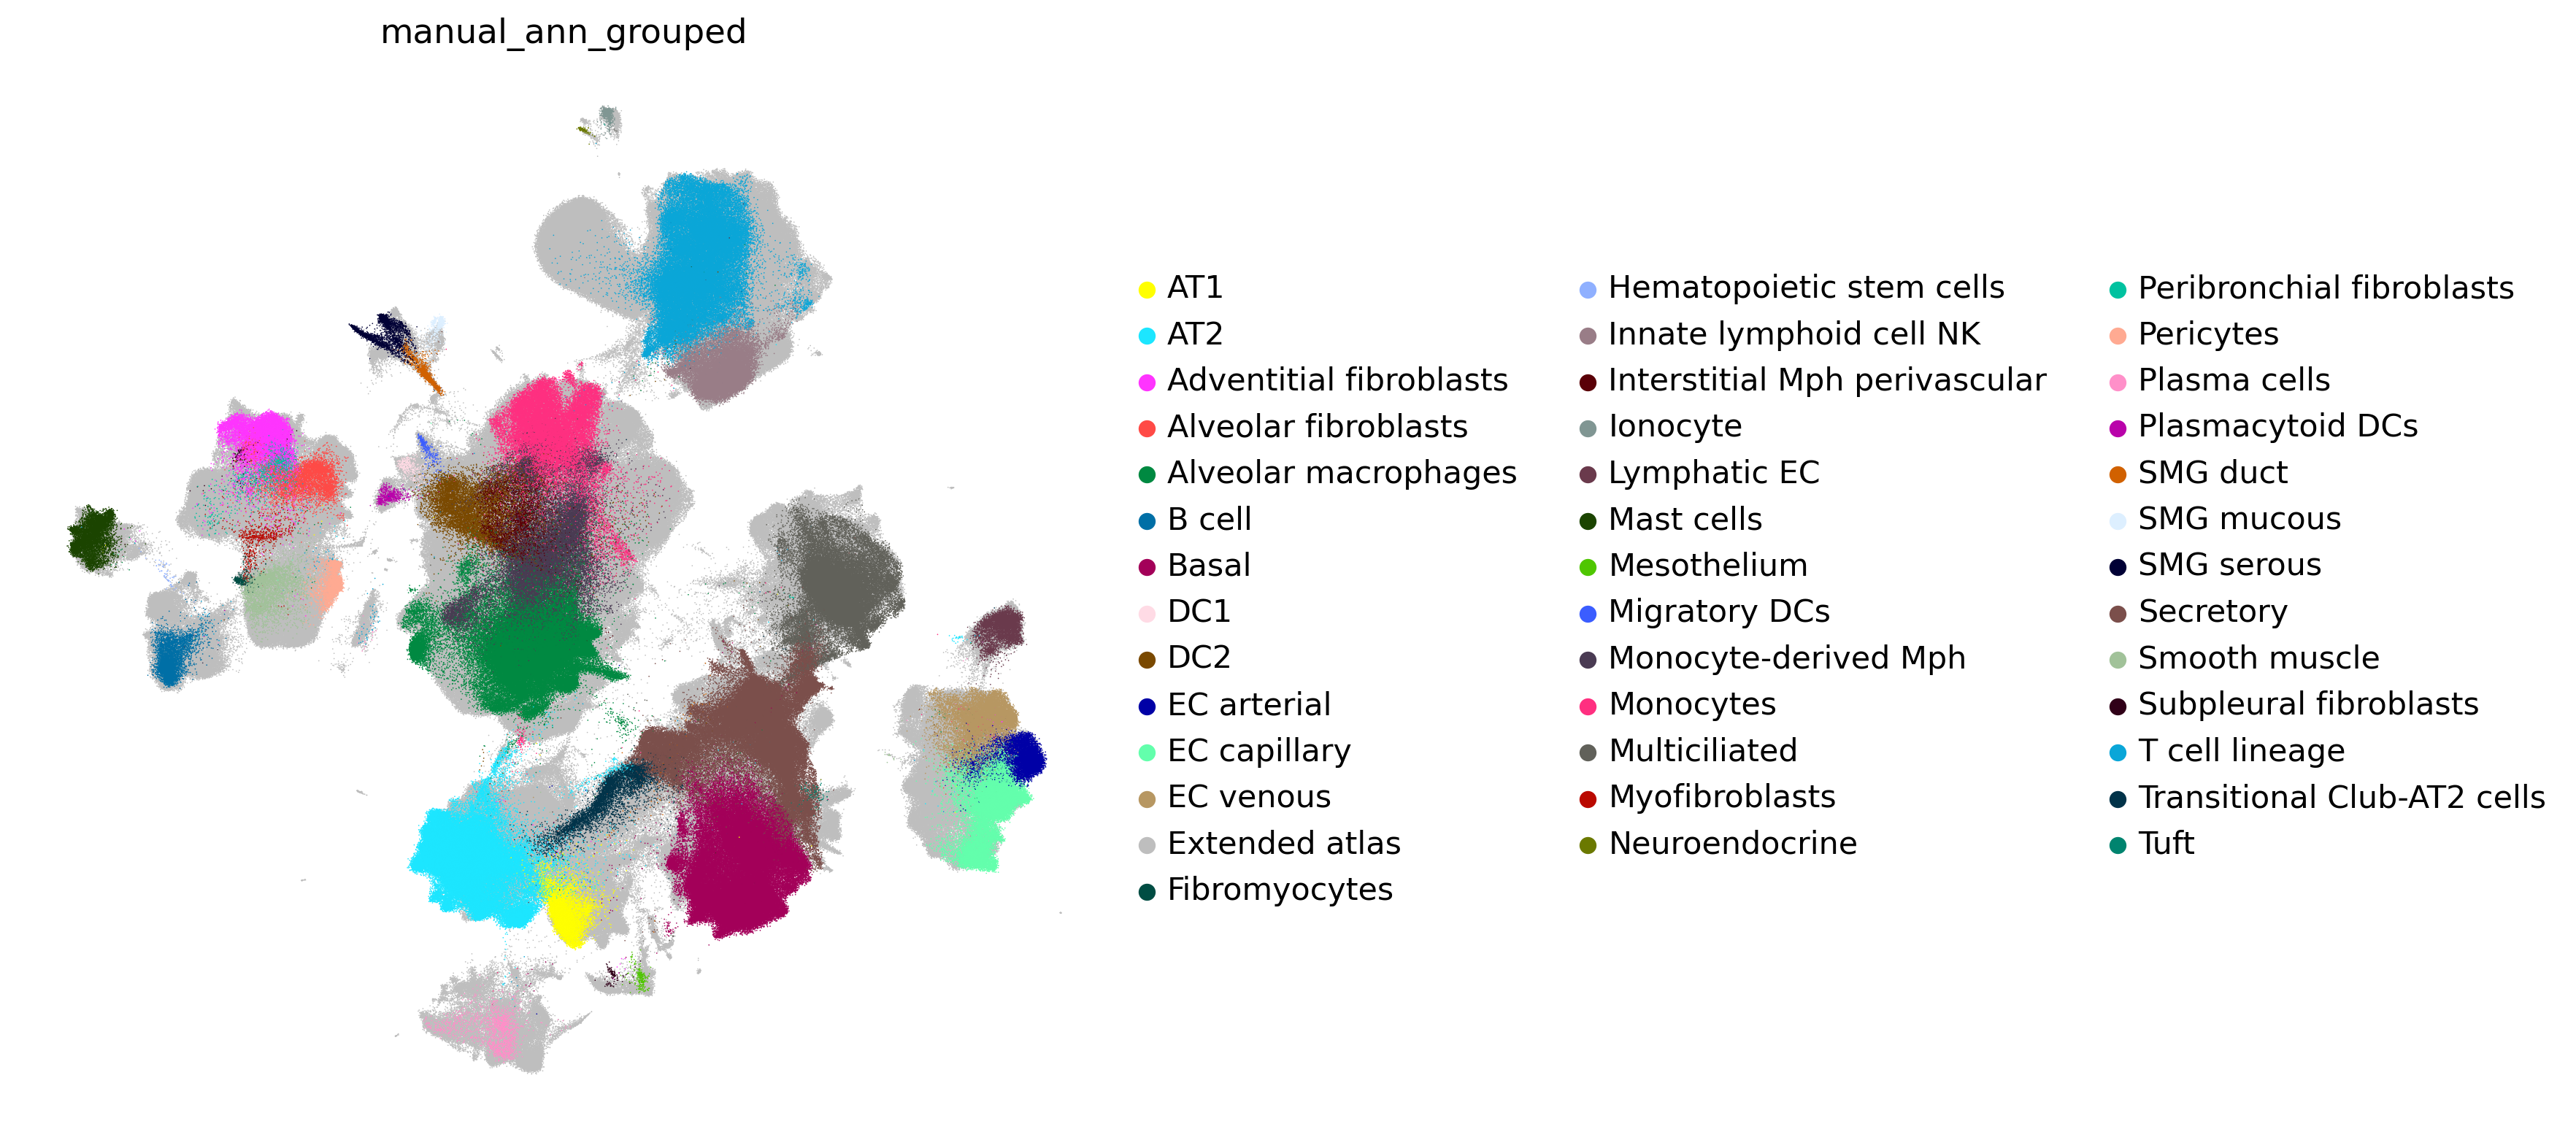

In [20]:
umap_ext_atlas = sc.pl.umap(
    full_latent_ext_first,
    color="manual_ann_grouped",
    palette=cols_new,
    frameon=False,
    size=1,
    return_fig=True,
)

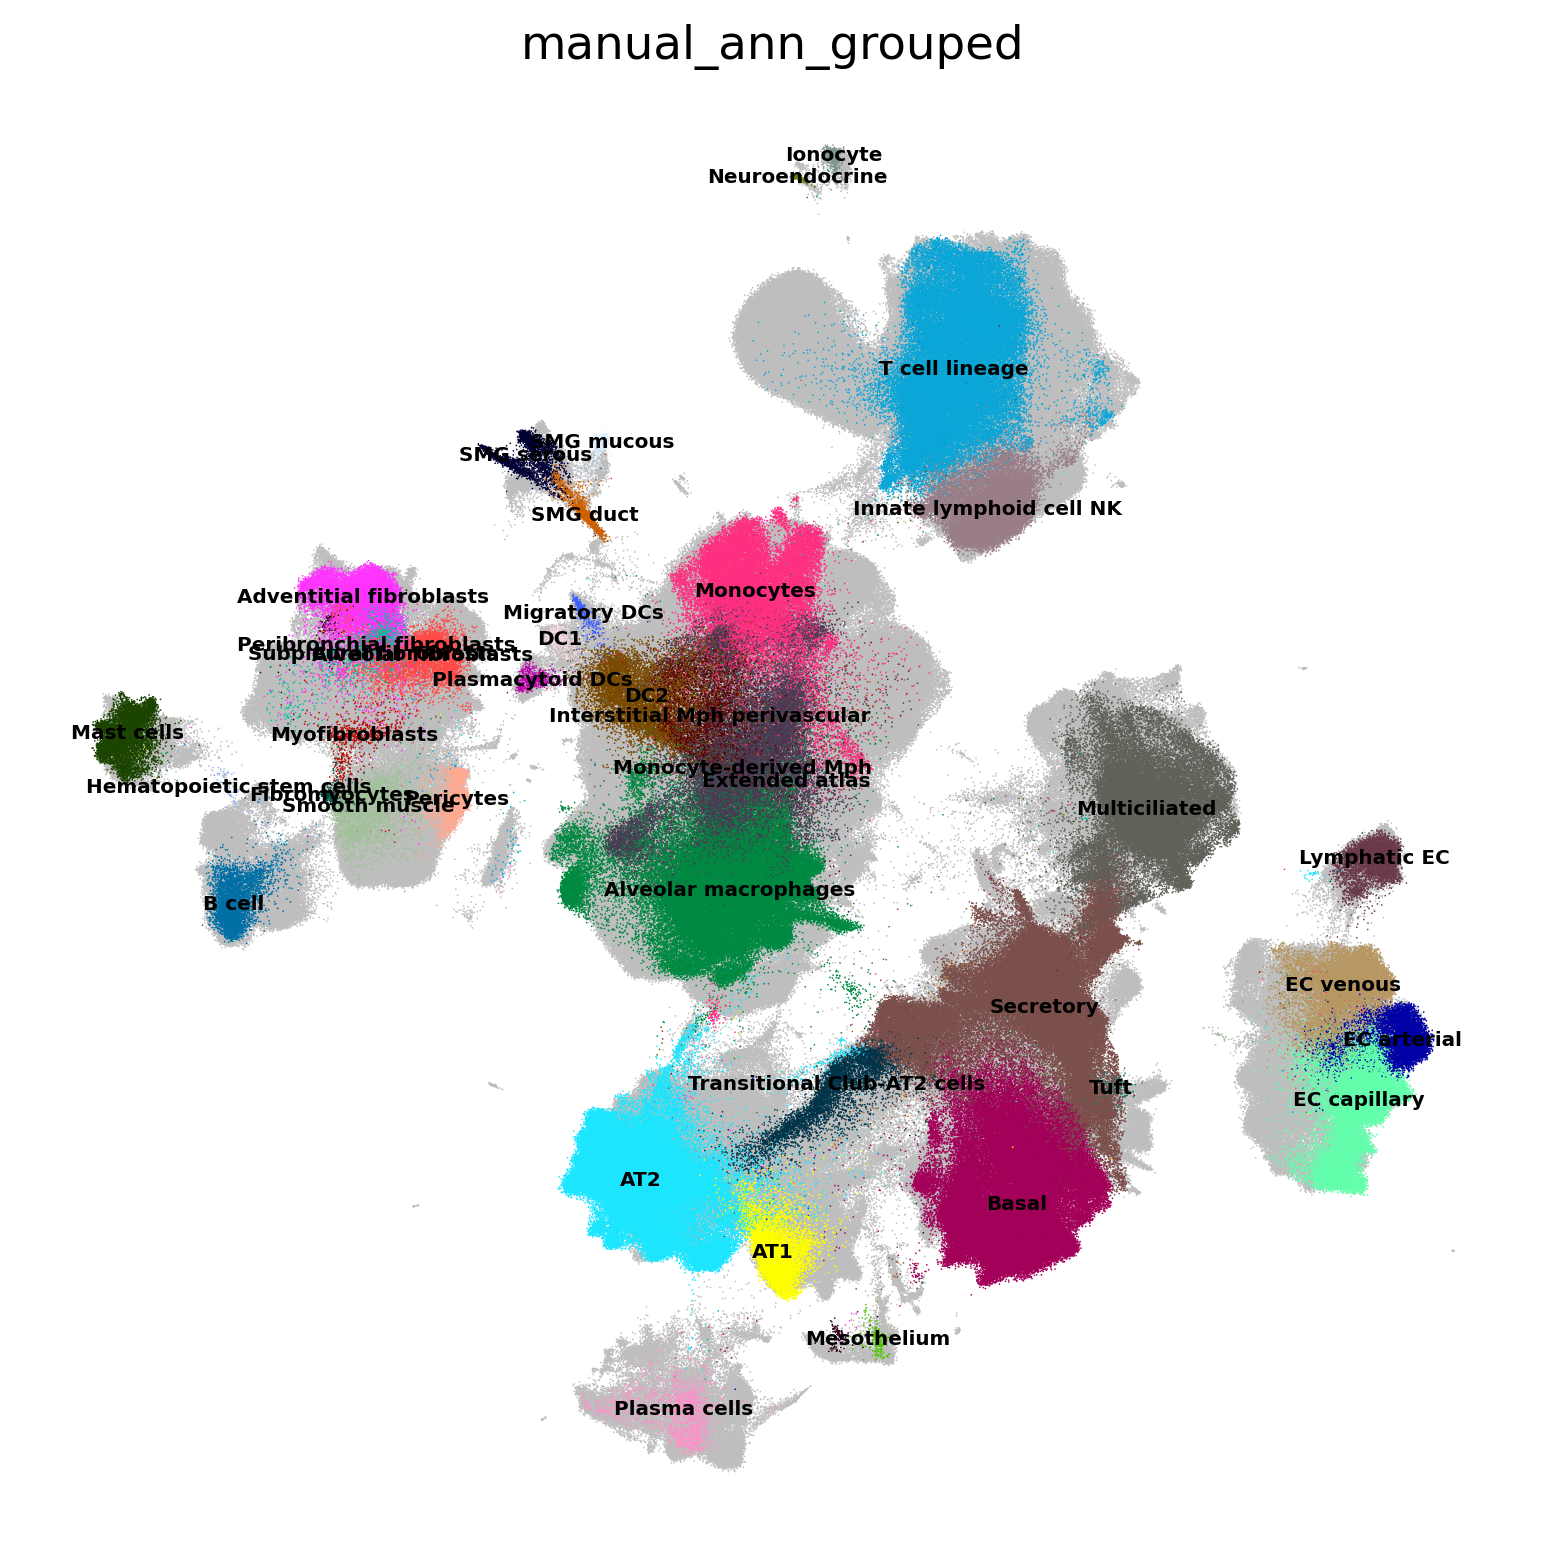

In [21]:
umap_ext_atlas_leg_in_fig = sc.pl.umap(
    full_latent_ext_first,
    color="manual_ann_grouped",
    legend_loc="on data",
    legend_fontsize=6,
    palette=cols_new,
    frameon=False,
    size=1,
    return_fig=True,
)

Store:

In [22]:
umap_ext_atlas.savefig(
    os.path.join(dir_figures, "6a_umap_ext_atlas.png"),
    bbox_inches="tight",
    dpi=140,
    transparent=True,
)

In [23]:
umap_ext_atlas_leg_in_fig.savefig(
    os.path.join(dir_figures, "6a_umap_ext_atlas_leg_in_fig.png"),
    bbox_inches="tight",
    dpi=140,
    transparent=True,
)